# Anomaly detection（异常检测）

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat

In [2]:
data = loadmat('data/ex8data1.mat')
X = data['X']
X.shape

(307, 2)

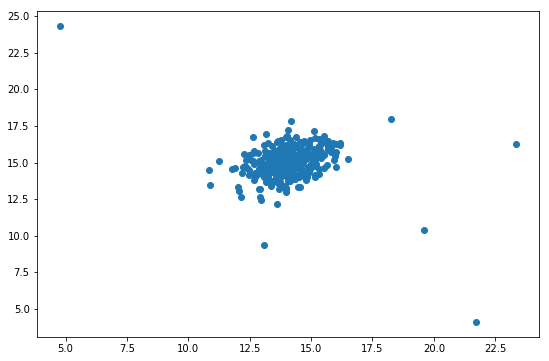

In [3]:
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(X[:,0], X[:,1])
plt.show()

In [4]:
def estimate_gaussian(X):
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)
    
    return mu, sigma

In [10]:
mu, sigma = estimate_gaussian(X)
mu, sigma

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

In [12]:
Xval = data['Xval']
yval = data['yval']

Xval.shape, yval.shape

((307, 2), (307, 1))

### 我们还需要一种计算数据点属于正态分布的概率的方法。 幸运的是SciPy有这个内置的方法。

In [13]:
from scipy import stats
dist = stats.norm(mu[0], sigma[0])
dist.pdf(15)

0.1935875044615038

### 将数组传递给概率密度函数，并获得数据集中每个点的概率密度。

In [17]:
dist.pdf(X[:,0])[0:10]

array([0.183842  , 0.20221694, 0.21746136, 0.19778763, 0.20858956,
       0.21652359, 0.16991291, 0.15123542, 0.1163989 , 0.1594734 ])

In [18]:
p = np.zeros((X.shape[0], X.shape[1]))
p[:,0] = stats.norm(mu[0], sigma[0]).pdf(X[:,0])
p[:,1] = stats.norm(mu[1], sigma[1]).pdf(X[:,1])

p.shape

(307, 2)

### 为验证集（使用相同的模型参数）执行此操作。 我们将使用与真实标签组合的这些概率来确定将数据点分配为异常的最佳概率阈值。

In [21]:
pval = np.zeros((Xval.shape[0], Xval.shape[1]))
pval[:,0] = stats.norm(mu[0], sigma[0]).pdf(Xval[:,0])
pval[:,1] = stats.norm(mu[1], sigma[1]).pdf(Xval[:,1])

pval.shape

(307, 2)

In [23]:
def select_threshold(pval, yval):
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    
    step = (pval.max() - pval.min()) / 1000
    
    for epsilon in np.arange(pval.min(), pval.max(), step):
        preds = pval < epsilon
        
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    
    return best_epsilon, best_f1

In [26]:
epsilon, f1 = select_threshold(pval, yval)
epsilon, f1

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


(0.009566706005956842, 0.7142857142857143)

In [33]:
# indexes of the values considered to be outliers
outliers = np.where(p < epsilon)
outliers

(array([300, 301, 301, 303, 303, 304, 306, 306]),
 array([1, 0, 1, 0, 1, 0, 0, 1]))

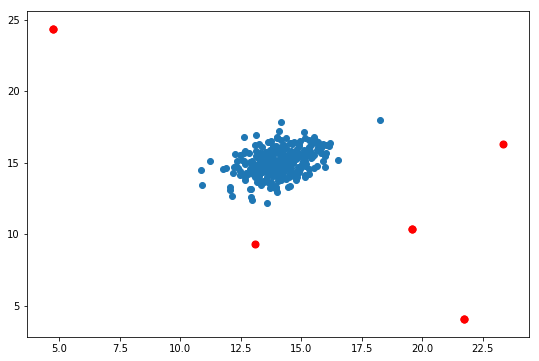

In [34]:
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(X[:,0], X[:,1])
ax.scatter(X[outliers[0],0], X[outliers[0],1], s=50, color='r', marker='o')
plt.show()